
# ShakeMap (Boore 2008 style) → Excel
โน้ตบุ๊กนี้แปลงจากโค้ด VB เดิมให้ **กรอกตัวเลขเอง** (แทนการอ่านไฟล์ `Eq_Parameter`) แล้วคำนวณค่า **PGA %g[Boore,2008]** บนกริดละติจูด-ลองจิจูด และ **บันทึกเป็นไฟล์ Excel**

## สิ่งที่ได้
- รับค่าพารามิเตอร์: `lat, lon, mag, strike, dip, rake, depth` และการตั้งค่ากริด
- คำนวณร่องรอยรอยเลื่อนบนผิวดิน (rupture trace) แบบเส้นตามความยาวรอยเลื่อน
- หาระยะ Rjb (ระยะฉายบนผิวดินถึงรอยเลื่อน) ที่ใกล้สุด
- ใช้สมการแบบในโค้ด VB (Boore 2008 terms) เพื่อประมาณ PGA
- ส่งออกไฟล์ **Excel**: `Lon, Lat, PGA %g[Boore,2008], Rup Dist(km)`

> หมายเหตุ: สูตรและคงที่ต่าง ๆ อ้างอิงตามโค้ด VB ที่คุณให้ไว้


In [110]:

import math
import numpy as np
import pandas as pd
!pip install folium openpyxl
!pip install pykrige
!pip install haversine
!pip install gmplot
# ถ้าอยากบันทึกเป็น .xlsx ต้องมี openpyxl
# !pip install openpyxl  # เปิดคอมเมนต์หากยังไม่มี


# **แบบกรอกข้อมูล**

In [133]:
# shakemap_vb_match.py (fixed to match VB numerics)
# - ยึดค่าพายและสูตรเดียวกับ VB ให้ตัวเลข "ตรงกันมากขึ้น"
# - ถามเฉพาะ lat, lon, mag, depth แล้วเขียนผลเป็น shakemap.xlsx

import math
import numpy as np
import pandas as pd

def _prompt_float(prompt, default):
    s = input(f"{prompt} [default={default}]: ").strip()
    return float(s) if s else float(default)

print("กรอกพารามิเตอร์เหตุการณ์แผ่นดินไหว (Enter ว่าง = ใช้ค่าเริ่มต้น)")
lat   = _prompt_float("ละติจูดศูนย์กลางเหตุการณ์ (lat, °)", 18.0)
lon   = _prompt_float("ลองจิจูดศูนย์กลางเหตุการณ์ (lon, °)", 99.0)
mag   = _prompt_float("ขนาดแมกนิจูด (Mw)", 5.5)
depth = _prompt_float("ความลึก Hypocenter (km)", 7.0)

# ===== ค่าคงที่/ดีฟอลต์ =====
strike       = 0.0
dip          = 45.0
rake         = 0.0
half_box_deg = 2.0
spacing      = 0.05
dl_km        = 0.1      # ระยะก้าวตามแนวรอยเลื่อน (km)
out_xlsx     = "shakemap.xlsx"

# ===== ค่าพายแบบ VB =====
PI_STRIKE   = 3.14              # ใช้กับ sin/cos(strike)
PI_COSLAT   = 3.14159265359     # ใช้กับ Cos(lat*pi/180) ตอนคำนวณระยะ
DEG2RAD_S   = PI_STRIKE / 180.0
DEG2RAD_LAT = PI_COSLAT / 180.0

# ===== พารามิเตอร์ Boore 2008 ตาม VB =====
blin = -0.36; b1 = -0.64; b2 = -0.14  # (ไม่ใช้ตรง ๆ แต่คงไว้)
c1 = -0.6605; c2 = 0.1197; c3 = -0.01151; h = 1.35
Mref = 4.5; Rref = 1.0
e1 = -0.538; e2 = -0.5035; e3 = -0.7547; e4 = -0.5097; e5 = 0.2881; e6 = -0.1016; e7 = 0.0; mh = 6.75

# 1) ขนาดรอยเลื่อนแบบง่าย (ตาม VB)
a_km2 = 10 ** ((mag - 4.07) / 0.98)   # พื้นที่ (km^2)
w_km  = math.sqrt(a_km2 / 2.0)        # ความกว้าง
L_km  = 2.0 * w_km                    # ความยาว
ztor  = depth - (w_km * math.sin(dip * math.pi/180.0) / 2.0)
ztor  = max(0.0, ztor)                # ถ้าติดลบให้เป็น 0 (ตาม VB)

# 2) สร้าง trace บนผิวดินตาม strike (ใช้ PI_STRIKE)
cosS = math.cos(strike * DEG2RAD_S)
sinS = math.sin(strike * DEG2RAD_S)
dlat0 = (L_km * 0.5 * cosS) / 111.0
dlon0 = (L_km * 0.5 * sinS) / 111.0
latR0 = lat - dlat0
lonR0 = lon - dlon0

n_seg = max(1, int(max(1.0, L_km) / dl_km))
ii = np.arange(1, n_seg + 1, dtype=float)
latR = latR0 + (dl_km * ii * cosS) / 111.0
lonR = lonR0 + (dl_km * ii * sinS) / 111.0

# 3) กลไกการแตกจาก rake → flags และ u (ตาม VB)
ss = 0.0; ns = 0.0; rs = 0.0; u = 1.0
if (-180 < rake < -150) or (-30 < rake < 30) or (150 < rake < 180):
    ss, u = 1.0, 0.0
elif -120 <= rake <= -60:
    ns, u = 1.0, 0.0
elif 30 <= rake <= 150:
    rs, u = 1.0, 0.0

# 4) ตัวประกอบขนาดแผ่นดินไหว Fm
if mag <= mh:
    Fm = e1*u + e2*ss + e3*ns + e4*rs + e5*(mag - mh) + e6*((mag - mh)**2)
else:
    Fm = e1*u + e2*ss + e3*ns + e4*rs + e7*(mag - mh)

# 5) กริดพิกัด
lat_vals = np.arange(lat - half_box_deg, lat + half_box_deg + 1e-12, spacing)
lon_vals = np.arange(lon - half_box_deg, lon + half_box_deg + 1e-12, spacing)
LAT, LON = np.meshgrid(lat_vals, lon_vals, indexing="ij")  # [Ny, Nx]

# 6) คำนวณ Rjb (ใช้ PI_COSLAT สำหรับ cos(lat*pi/180))
Ny, Nx = LAT.shape
LAT3 = LAT[:, :, None]
LON3 = LON[:, :, None]
latR_arr = latR.reshape(1, 1, -1)
lonR_arr = lonR.reshape(1, 1, -1)

coslat = np.cos(LAT3 * DEG2RAD_LAT)  # <<< ตรง VB
dx_km = (lonR_arr - LON3) * coslat * 111.0
dy_km = (latR_arr - LAT3) * 111.0
dist_all = np.sqrt(dx_km**2 + dy_km**2)
Rjb = dist_all.min(axis=2)

# 7) R3, 8) Fd, 9) PGA (%g) ตาม VB
R3 = np.sqrt(Rjb**2 + h**2)
Fd = (c1 + c2*(mag - Mref)) * np.log(R3 / Rref) + c3 * (R3 - Rref)
PGA = np.exp(Fm + Fd) * 100.0

# 10) ออกเป็น DataFrame และบันทึก
out = pd.DataFrame({
    "Lon": LON.ravel(order="C"),
    "Lat": LAT.ravel(order="C"),
    "PGA %g[Boore,2008]": PGA.ravel(order="C"),
    "Rup Dist(km)": Rjb.ravel(order="C"),
})
print("ตัวอย่างข้อมูล 10 แถวแรก:")
print(out.head(10))
print(f"จำนวนจุดทั้งหมด: {len(out)}")

out.to_excel(out_xlsx, index=False)  # <<< แก้จาก df -> out
print("บันทึกไฟล์:", out_xlsx)
print("ค่าสูงสุด/ต่ำสุดของ PGA (%g):", float(PGA.min()), float(PGA.max()))


กรอกพารามิเตอร์เหตุการณ์แผ่นดินไหว (Enter ว่าง = ใช้ค่าเริ่มต้น)
ละติจูดศูนย์กลางเหตุการณ์ (lat, °) [default=18.0]: 14.7
ลองจิจูดศูนย์กลางเหตุการณ์ (lon, °) [default=99.0]: 98.9
ขนาดแมกนิจูด (Mw) [default=5.5]: 6.5
ความลึก Hypocenter (km) [default=7.0]: 2
ตัวอย่างข้อมูล 10 แถวแรก:
     Lon   Lat  PGA %g[Boore,2008]  Rup Dist(km)
0  96.90  12.7            0.158824    301.538457
1  96.95  12.7            0.166953    297.673740
2  97.00  12.7            0.175399    293.857954
3  97.05  12.7            0.184164    290.093031
4  97.10  12.7            0.193248    286.380976
5  97.15  12.7            0.202650    282.723872
6  97.20  12.7            0.212366    279.123878
7  97.25  12.7            0.222392    275.583233
8  97.30  12.7            0.232719    272.104254
9  97.35  12.7            0.243339    268.689336
จำนวนจุดทั้งหมด: 6561
บันทึกไฟล์: shakemap.xlsx
ค่าสูงสุด/ต่ำสุดของ PGA (%g): 0.15882406165032464 49.05073948371338


# **API**

In [137]:
# shakemap_from_TMD_latest_TH.py
# ดึงเหตุการณ์ "ล่าสุดในไทย" จาก TMD -> คำนวณ PGA แบบ VB -> เซฟเป็น shakemap.xlsx

import re
import math
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

TMD_URL = "https://earthquake.tmd.go.th/inside.html"

# -------------------- Utilities --------------------
def _clean_num(s: str) -> float:
    return float(re.sub(r"[^0-9.\-]", "", s))

def _parse_latlon(lat_s: str, lon_s: str):
    lat = _clean_num(lat_s)
    lon = _clean_num(lon_s)
    s_lat = lat_s.strip().upper()
    s_lon = lon_s.strip().upper()
    if s_lat.endswith(("S", "ใต้")):
        lat = -lat
    if s_lon.endswith(("W", "ตะวันตก")):
        lon = -lon
    return lat, lon

def _looks_region_th(s: str) -> bool:
    return any(k in s for k in ("ประเทศไทย", "จ.", "อ.", "ต.", "ตำบล", "อำเภอ", "จังหวัด"))

def fetch_latest_event_in_thailand():
    headers = {"User-Agent": "Mozilla/5.0"}
    html = requests.get(TMD_URL, timeout=20, headers=headers).text
    soup = BeautifulSoup(html, "html.parser")
    lines = [ln.strip() for ln in soup.get_text("\n").splitlines() if ln.strip()]

    events = []
    i = 0
    re_mag = re.compile(r"^[0-9]+(?:\.[0-9]+)?$")
    re_deg = re.compile(r"^[\-]?[0-9]+(?:\.[0-9]+)?\s*°\s*[NSEW]?$", re.IGNORECASE)
    re_num = re.compile(r"^[\-]?[0-9]+(?:\.[0-9]+)?$")

    while i < len(lines) - 5:
        s_mag = lines[i]
        if re_mag.fullmatch(s_mag):
            lat_s = lines[i+1] if i+1 < len(lines) else ""
            lon_s = lines[i+2] if i+2 < len(lines) else ""
            dep_s = lines[i+3] if i+3 < len(lines) else ""
            cand4 = lines[i+4] if i+4 < len(lines) else ""
            cand5 = lines[i+5] if i+5 < len(lines) else ""
            region_s = cand5 if re_num.fullmatch(cand4 or "") else cand4

            dep_num_s = re.sub(r"[^0-9.\-]", "", dep_s) or "0"
            if re_deg.fullmatch(lat_s) and re_deg.fullmatch(lon_s) and re_num.fullmatch(dep_num_s):
                try:
                    mag = float(s_mag)
                    lat, lon = _parse_latlon(lat_s, lon_s)
                    depth = float(dep_num_s)
                    events.append(dict(mag=mag, lat=lat, lon=lon, depth=depth, region=region_s))
                    i += 6
                    continue
                except Exception:
                    pass
        i += 1

    if not events:
        return None
    for ev in events:
        if _looks_region_th(ev["region"]):
            return ev
    return events[0]

# -------------------- 1) Fetch TMD --------------------
ev = fetch_latest_event_in_thailand()
if not ev:
    raise SystemExit("❌ ดึงเหตุการณ์จาก TMD ไม่สำเร็จ หรือหน้าเว็บเปลี่ยนรูปแบบ")

lat   = ev["lat"]
lon   = ev["lon"]
mag   = ev["mag"]
depth = ev["depth"]
print(f"เหตุการณ์ที่ใช้จาก TMD: Mw={mag:.2f}, lat={lat:.4f}, lon={lon:.4f}, depth={depth:.2f} km, region='{ev['region']}'")

# -------------------- 2) คำนวณ PGA แบบ VB --------------------
strike       = 0.0
dip          = 45.0
rake         = 0.0
half_box_deg = 2.0
spacing      = 0.05
dl_km        = 0.1

PI_STRIKE   = 3.14
PI_COSLAT   = 3.14159265359
DEG2RAD_S   = PI_STRIKE/180.0
DEG2RAD_LAT = PI_COSLAT/180.0

c1 = -0.6605; c2 = 0.1197; c3 = -0.01151; h = 1.35
Mref = 4.5; Rref = 1.0
e1 = -0.538; e2 = -0.5035; e3 = -0.7547; e4 = -0.5097; e5 = 0.2881; e6 = -0.1016; e7 = 0.0; mh = 6.75

# === กริด "รวมขอบบน" ให้ได้ 81x81 = 6561 จุด ===
latmin = lat - half_box_deg
latmax = lat + half_box_deg
lonmin = lon - half_box_deg
lonmax = lon + half_box_deg

n_lat = int(round((latmax - latmin) / spacing)) + 1  # 80 + 1 = 81
n_lon = int(round((lonmax - lonmin) / spacing)) + 1  # 80 + 1 = 81

lat_vals = np.linspace(latmin, latmax, n_lat)
lon_vals = np.linspace(lonmin, lonmax, n_lon)
LAT, LON = np.meshgrid(lat_vals, lon_vals, indexing="ij")  # [81,81]

# เรขาคณิตรอยเลื่อน
a_km2 = 10 ** ((mag - 4.07) / 0.98)
w_km  = math.sqrt(a_km2 / 2.0)
L_km  = 2.0 * w_km
ztor  = depth - (w_km * math.sin(dip * math.pi/180.0) / 2.0)
ztor  = max(0.0, ztor)

cosS = math.cos(strike * DEG2RAD_S)
sinS = math.sin(strike * DEG2RAD_S)
latR0 = lat - (L_km * 0.5 * cosS) / 111.0
lonR0 = lon - (L_km * 0.5 * sinS) / 111.0
n_seg = max(1, int(L_km / dl_km))
ii = np.arange(1, n_seg + 1, dtype=float)
latR = latR0 + (dl_km * ii * cosS) / 111.0
lonR = lonR0 + (dl_km * ii * sinS) / 111.0

# กลไกจาก rake
ss = ns = rs = 0.0; u = 1.0
if (-180 < rake < -150) or (-30 < rake < 30) or (150 < rake < 180):
    ss, u = 1.0, 0.0
elif -120 <= rake <= -60:
    ns, u = 1.0, 0.0
elif 30 <= rake <= 150:
    rs, u = 1.0, 0.0

# Fm
if mag <= mh:
    Fm = e1*u + e2*ss + e3*ns + e4*rs + e5*(mag - mh) + e6*((mag - mh)**2)
else:
    Fm = e1*u + e2*ss + e3*ns + e4*rs + e7*(mag - mh)

# ระยะ Rjb
LAT3 = LAT[:, :, None]; LON3 = LON[:, :, None]
latR_arr = latR.reshape(1, 1, -1); lonR_arr = lonR.reshape(1, 1, -1)
coslat = np.cos(LAT3 * DEG2RAD_LAT)
dx_km  = (lonR_arr - LON3) * coslat * 111.0
dy_km  = (latR_arr - LAT3) * 111.0
Rjb = np.sqrt(dx_km**2 + dy_km**2).min(axis=2)

# R3, Fd, PGA
R3 = np.sqrt(Rjb**2 + h**2)
Fd = (c1 + c2*(mag - Mref)) * np.log(R3 / Rref) + c3 * (R3 - Rref)
PGA = np.exp(Fm + Fd) * 100.0

# ส่งออก
out = pd.DataFrame({
    "Lon": LON.ravel(order="C"),
    "Lat": LAT.ravel(order="C"),
    "PGA %g[Boore,2008]": PGA.ravel(order="C"),
    "Rup Dist(km)": Rjb.ravel(order="C"),
})
print("ตัวอย่างข้อมูล 10 แถวแรก:")
print(out.head(10))
print(f"จำนวนจุดทั้งหมด: {len(out)}")  # ควรพิมพ์ 6561

out.to_excel("shakemap.xlsx", index=False)
print("✅ บันทึกไฟล์: shakemap.xlsx")
print("ค่าสูงสุด/ต่ำสุดของ PGA (%g):", float(PGA.min()), float(PGA.max()))


เหตุการณ์ที่ใช้จาก TMD: Mw=1.70, lat=19.6570, lon=98.9830, depth=1.00 km, region='ต.เมืองนะ อ.เชียงดาว จ.เชียงใหม่'
ตัวอย่างข้อมูล 10 แถวแรก:
      Lon     Lat  PGA %g[Boore,2008]  Rup Dist(km)
0  96.983  17.657            0.000105    306.690057
1  97.033  17.657            0.000111    303.066446
2  97.083  17.657            0.000117    299.492382
3  97.133  17.657            0.000123    295.969662
4  97.183  17.657            0.000129    292.500141
5  97.233  17.657            0.000136    289.085732
6  97.283  17.657            0.000143    285.728414
7  97.333  17.657            0.000150    282.430220
8  97.383  17.657            0.000158    279.193247
9  97.433  17.657            0.000166    276.019649
จำนวนจุดทั้งหมด: 6561
✅ บันทึกไฟล์: shakemap.xlsx
ค่าสูงสุด/ต่ำสุดของ PGA (%g): 0.00010476270397664595 0.780361037819588


# **สร้างแผนที่จากข้อมูล**

✅ สร้างภาพ 'pga_kriging_softmask.png' (Kriging + Soft Mask)
✅ บันทึกแผนที่เป็นไฟล์ HTML: pga_kriging_softmask_map.html



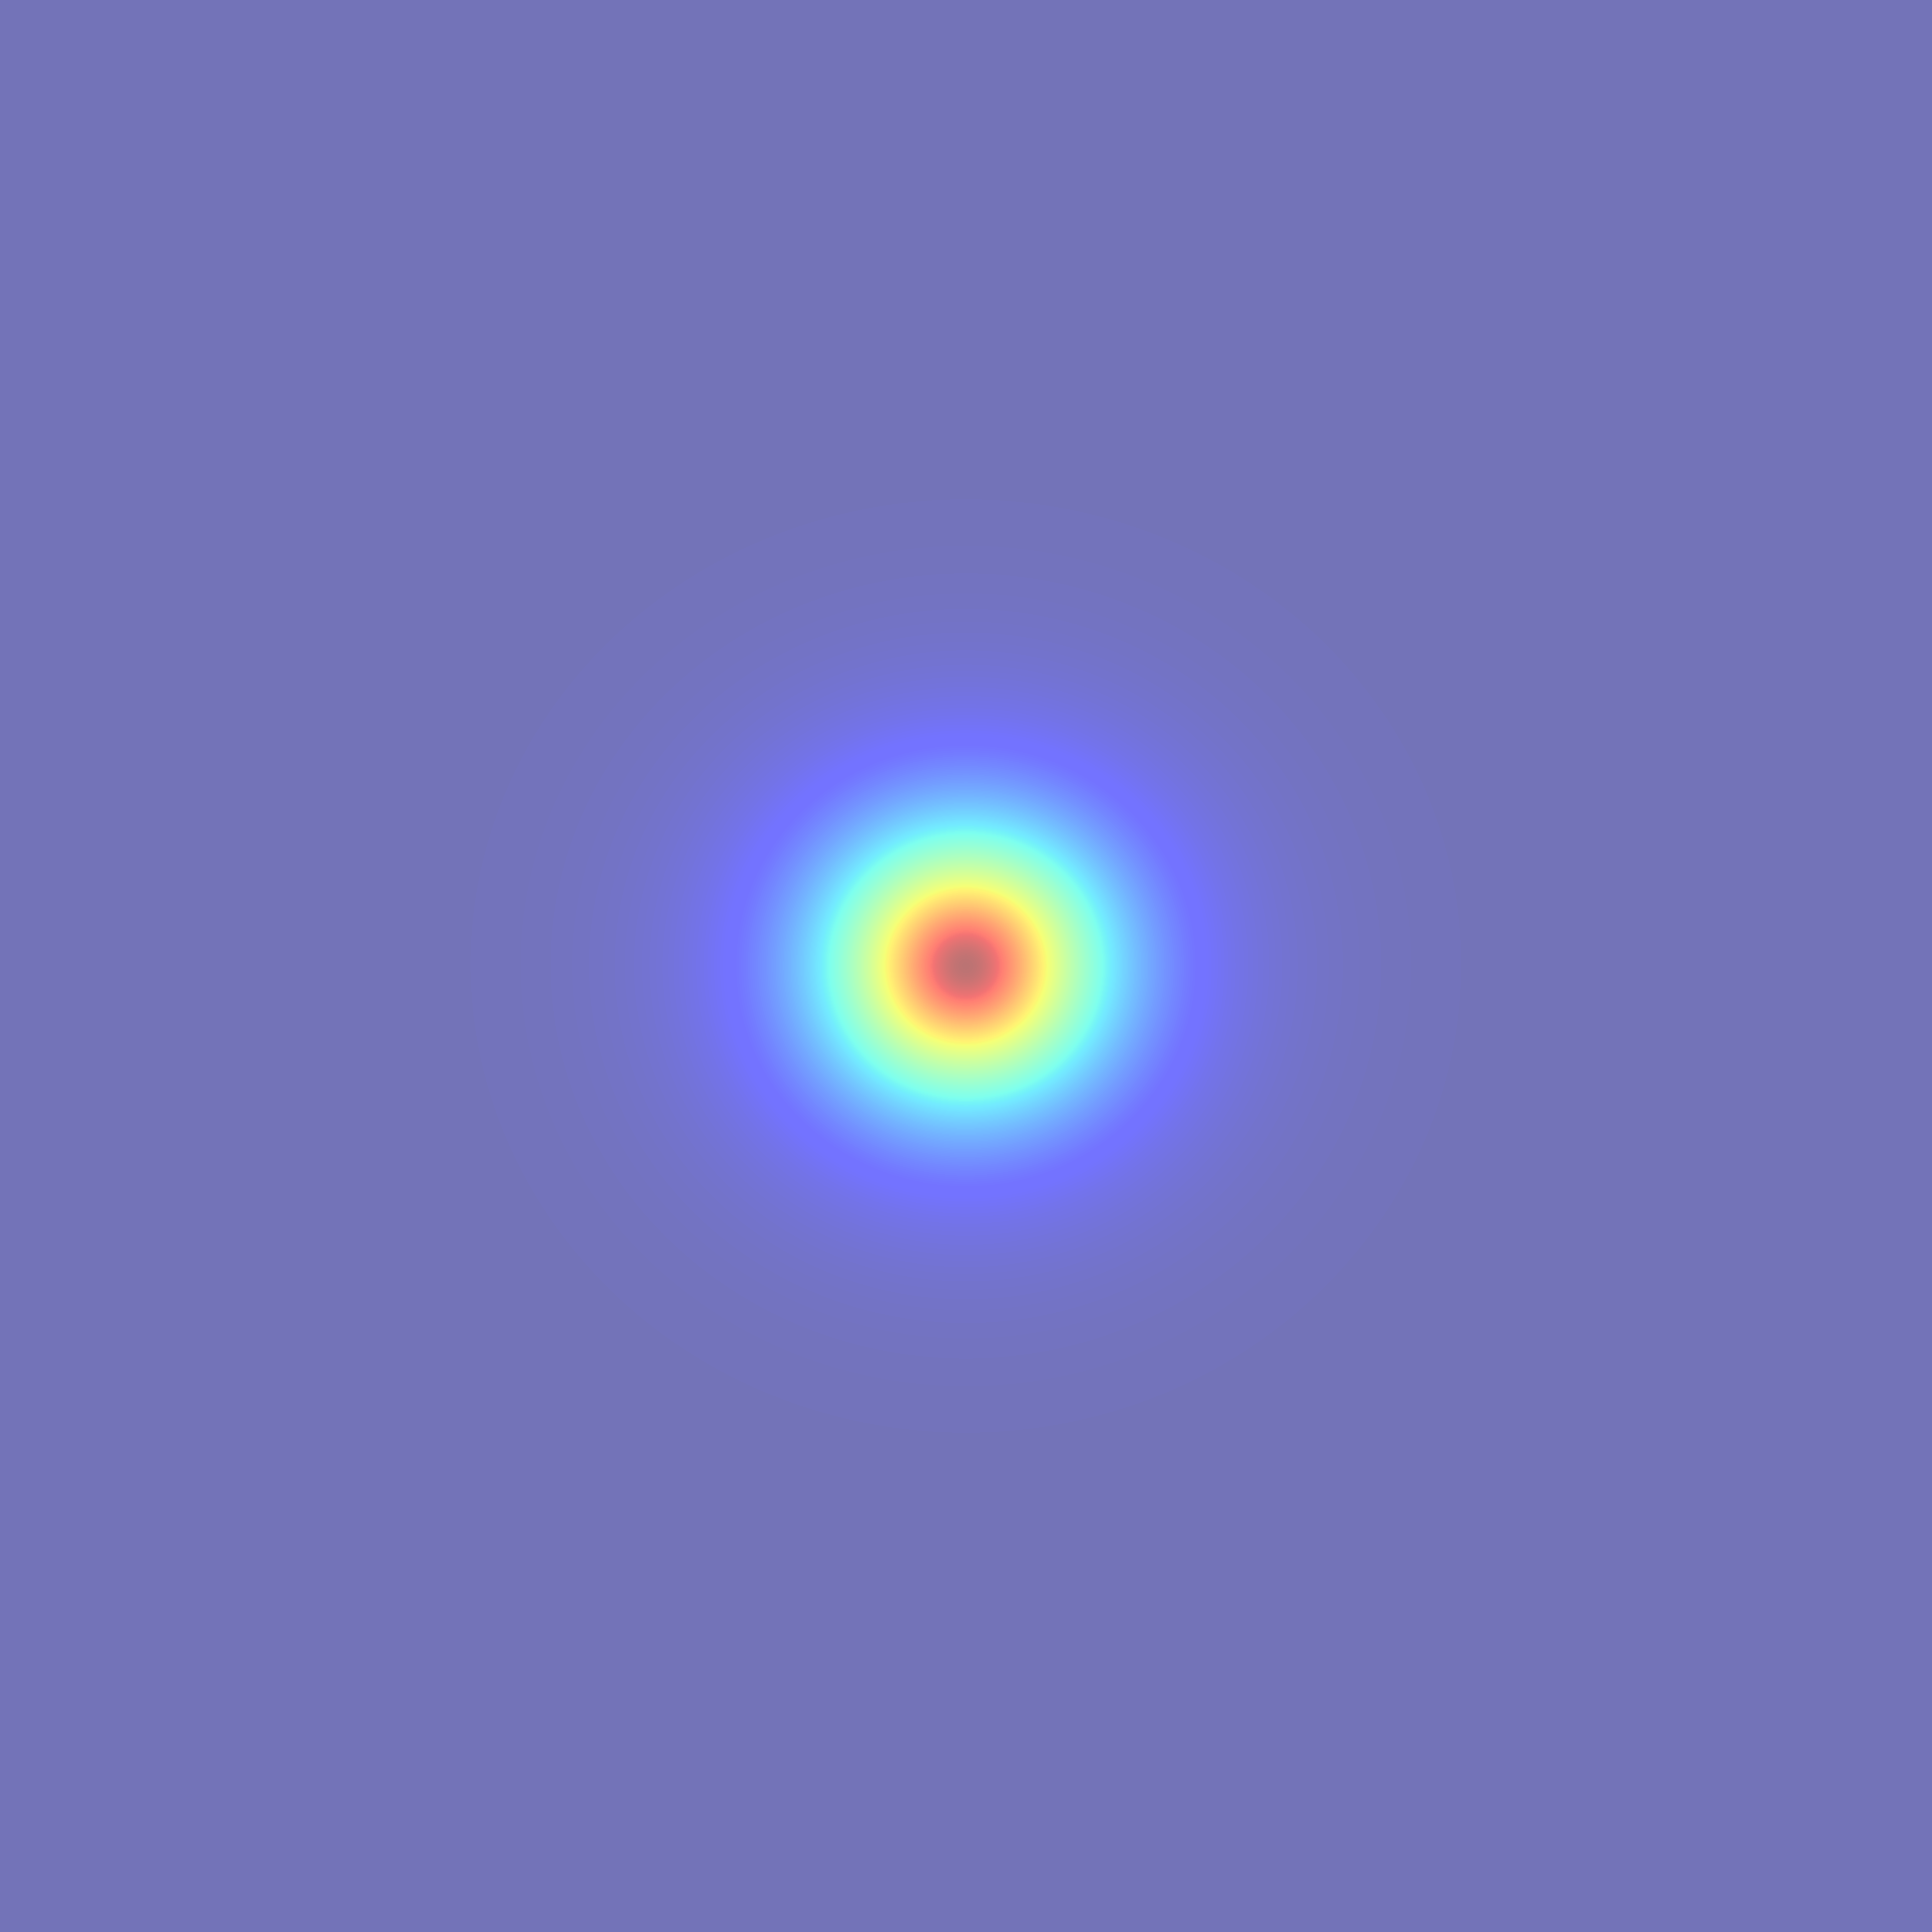

In [135]:
# === ใช้ข้อมูลจาก shakemap.xlsx โดยตรง ===
import os
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# ถ้ามี pykrige จะใช้ OrdinaryKriging; ถ้าไม่มีจะ fallback เป็น scipy.griddata
try:
    from pykrige.ok import OrdinaryKriging
    _HAS_KRIGE = True
except Exception:
    from scipy.interpolate import griddata
    _HAS_KRIGE = False

# ---------------- CONFIG ----------------
xlsx_path = "/content/shakemap.xlsx"      # ชื่อไฟล์ตามที่แสดงใน Colab Files
pga_column = "PGA %g[Boore,2008]"         # ชื่อคอลัมน์ PGA จากไฟล์ที่เราสร้าง
variogram = "linear"                      # 'linear' / 'spherical' / 'exponential' ฯลฯ (ถ้าใช้ pykrige)
grid_n = 120                              # ความหนาแน่นกริดสำหรับ interpolation (เช่น 100–200)
sigma_km = 50                             # ความกว้าง Gaussian soft mask (ยิ่งมาก ขอบยิ่งเนียน)
tiles = "OpenStreetMap"                   # แผนที่พื้นหลัง
zoom_start = 8                            # ระดับซูมเริ่มต้น
out_png = "pga_kriging_softmask.png"
out_html = "pga_kriging_softmask_map.html"
# ---------------------------------------

# 1) โหลดไฟล์ shakemap.xlsx
if not os.path.exists(xlsx_path):
    raise SystemExit(f"❌ ไม่พบไฟล์: {xlsx_path}")

df = pd.read_excel(xlsx_path)
df.columns = df.columns.str.strip()

required_cols = {"Lon", "Lat", pga_column}
if not required_cols.issubset(df.columns):
    raise SystemExit(f"❌ ไฟล์ต้องมีคอลัมน์: {required_cols}. แต่พบ: {set(df.columns)}")

# 2) หา epicenter จากค่าที่ PGA สูงสุด
epicenter_row = df.loc[df[pga_column].idxmax()]
epicenter = [float(epicenter_row["Lat"]), float(epicenter_row["Lon"])]

# 3) ขอบเขตพื้นที่
lat_min, lat_max = float(df["Lat"].min()), float(df["Lat"].max())
lon_min, lon_max = float(df["Lon"].min()), float(df["Lon"].max())

# สร้างกริดสำหรับการประมาณค่า
grid_lon = np.linspace(lon_min, lon_max, 100)
grid_lat = np.linspace(lat_min, lat_max, 100)
grid_lon2d, grid_lat2d = np.meshgrid(grid_lon, grid_lat)

# 4) Interpolation: Kriging (ถ้ามี) หรือ griddata (fallback)
x = df["Lon"].to_numpy(dtype=float)
y = df["Lat"].to_numpy(dtype=float)
z = df[pga_column].to_numpy(dtype=float)

if _HAS_KRIGE:
    OK = OrdinaryKriging(
        x, y, z,
        variogram_model=variogram,
        verbose=False,
        enable_plotting=False
    )
    grid_pga, _ = OK.execute("grid", grid_lon, grid_lat)
    grid_pga = np.asarray(grid_pga)
else:
    # fallback: cubic ถ้าจุดพอ; ถ้าไม่พอใช้ linear/nearest
    method = "cubic" if len(df) >= 16 else "linear"
    grid_pga = griddata(points=(x, y), values=z, xi=(grid_lon2d, grid_lat2d),
                        method=method)
    # เติมหลุมเป็น nearest
    if np.isnan(grid_pga).any():
        grid_pga_nn = griddata(points=(x, y), values=z, xi=(grid_lon2d, grid_lat2d),
                               method="nearest")
        grid_pga = np.where(np.isnan(grid_pga), grid_pga_nn, grid_pga)

# ทำความสะอาดค่า
grid_pga = np.where(np.isnan(grid_pga), 0.0, grid_pga)
grid_pga = np.where(grid_pga < 0, 0.0, grid_pga)

# 5) Soft mask แบบ Gaussian จาก epicenter (ระยะ geodesic แบบ haversine)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2.0 * R * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))

dist_km = haversine(epicenter[0], epicenter[1], grid_lat2d, grid_lon2d)
soft_mask = np.exp(-0.5 * (dist_km / sigma_km)**2)

# 6) ผสม Kriging + Soft Mask
masked_pga = grid_pga * soft_mask

# 7) วาด Heatmap เป็นภาพโปร่งพื้นหลัง
norm = Normalize(vmin=float(masked_pga.min()), vmax=float(masked_pga.max()))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(
    masked_pga,
    extent=[lon_min, lon_max, lat_min, lat_max],
    origin="lower",
    cmap="jet",
    norm=norm,
    alpha=0.55,
    interpolation="bicubic"
)
ax.axis("off")
plt.savefig(out_png, dpi=600, bbox_inches="tight", pad_inches=0, transparent=True)
plt.close(fig)
print(f"✅ สร้างภาพ '{out_png}' (Kriging + Soft Mask)")

# 8) วางภาพบนแผนที่ Folium
m = folium.Map(location=epicenter, zoom_start=zoom_start, tiles=tiles)

folium.raster_layers.ImageOverlay(
    image=out_png,
    bounds=[[lat_min, lon_min], [lat_max, lon_max]],
    opacity=0.55,
    name="PGA (Kriging + Soft Mask)"
).add_to(m)

popup_html = f"""
<b>Epicenter (max PGA)</b><br>
Lat: <b>{epicenter[0]:.4f}</b><br>
Lon: <b>{epicenter[1]:.4f}</b><br>
PGA<sub>max</sub>: <b>{epicenter_row[pga_column]:.6f} %g</b>
"""
folium.Marker(
    location=epicenter,
    popup=folium.Popup(popup_html, max_width=280, show=True),
    icon=folium.Icon(color="red", icon="star")
).add_to(m)

folium.LayerControl().add_to(m)

# 9) บันทึกแผนที่ HTML
m.save(out_html)
print(f"✅ บันทึกแผนที่เป็นไฟล์ HTML: {out_html}")

# แสดงแผนที่ในโน้ตบุ๊ก
m


In [136]:
# patch_map_add_nearby_pga.py
# ฟีเจอร์:
# - ใช้ PGA สูงสุดเป็นจุดศูนย์กลาง (EPICENTER)
# - Popup แสดงชื่อสถานที่ (คลิก = reverse geocode, ค้นหา = ใช้ชื่อจาก geocoder)
# - คลิก/ค้นหา/ปุ่มแชร์ตำแหน่ง ใช้ "หมุดเดียว" (clear แล้วปักใหม่)
# - แสดง: ระยะห่างจากจุดศูนย์กลาง, PGA, ระดับความรุนแรง (มีสี)
# - วาด "เส้นปะ" สีเด่นจาก EPICENTER → ตำแหน่งที่ถามค่า
# - ออปติไมซ์:
#     * nearest PGA ด้วย spatial bucket
#     * ปักหมุดทันที แล้วค่อยอัปเดตชื่อ (async)
#     * grid-cache รายย่าน + point-cache รายพิกัด
#     * multi-provider race (Nominatim + BigDataCloud + Photon) พร้อม timeout
#     * debounce คลิก/ค้นหา + ยกเลิกงาน geocode เก่า (AbortController)
#     * คูลดาวน์ locationfound กันอีเวนต์ซ้อน

import re
import json
from pathlib import Path
import pandas as pd

# ======= ตั้งค่าไฟล์ =======
IN_HTML  = "pga_kriging_softmask_map.html"
XLSX     = "shakemap.xlsx"  # ต้องมีคอลัมน์ Lon, Lat, "PGA %g[Boore,2008]"
OUT_HTML = "pga_kriging_softmask_map_enhanced.html"

# ======= 1) โหลด HTML =======
html = Path(IN_HTML).read_text(encoding="utf-8")

# ======= 2) หา map variable =======
m = re.search(r"var\s+(map_[A-Za-z0-9]+)\s*=\s*L\.map\(", html)
if not m:
    raise RuntimeError("หา map variable ไม่เจอ (pattern: var map_xxx = L.map(...))")
map_var = m.group(1)

# ======= 3) โหลดข้อมูล PGA =======
df = pd.read_excel(XLSX)
df.columns = df.columns.str.strip()
pga_col = "PGA %g[Boore,2008]"
required = {"Lon", "Lat", pga_col}
if not required.issubset(df.columns):
    raise SystemExit(f"ไฟล์ {XLSX} ต้องมีคอลัมน์ {required}")

points = [
    {"lat": float(round(row["Lat"], 6)),
     "lon": float(round(row["Lon"], 6)),
     "pga": float(round(row[pga_col], 9))}
    for _, row in df.iterrows()
]
points_json = json.dumps(points, separators=(",", ":"))

# EPICENTER = จุดที่ PGA สูงสุด
max_row = df.loc[df[pga_col].idxmax()]
epicenter = {"lat": float(round(max_row["Lat"], 6)),
             "lon": float(round(max_row["Lon"], 6))}
epicenter_js = json.dumps(epicenter, separators=(",", ":"))

# ======= 4) CSS =======
css_block = """
<!-- Injected plugin CSS -->
<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet.locatecontrol@0.79.0/dist/L.Control.Locate.min.css"/>
<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet.fullscreen@2.4.0/Control.FullScreen.css"/>
<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet-minimap@3.6.1/dist/Control.MiniMap.min.css"/>
<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet-measure@3.3.0/dist/leaflet-measure.css"/>
<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet-control-geocoder@2.4.0/dist/Control.Geocoder.css"/>
<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet.mouseposition@1.2.0/src/L.Control.MousePosition.css"/>
<style>
  .sev-badge{display:inline-block;padding:2px 8px;border-radius:9999px;font-weight:700;font-size:0.9em}
  .sev-low{background:#E6F4EA;color:#1F7A1F;border:1px solid #94D3A2}
  .sev-mid{background:#FFF4E5;color:#B54708;border:1px solid #F4C78B}
  .sev-high{background:#FEE2E2;color:#B91C1C;border:1px solid #FCA5A5}
</style>
"""

# ======= 5) JS (ออปติไมซ์) =======
js_block = f"""
<!-- Injected plugin JS -->
<script src="https://cdn.jsdelivr.net/npm/leaflet.locatecontrol@0.79.0/dist/L.Control.Locate.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/leaflet.fullscreen@2.4.0/Control.FullScreen.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/leaflet-minimap@3.6.1/dist/Control.MiniMap.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/leaflet-measure@3.3.0/dist/leaflet-measure.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/leaflet-control-geocoder@2.4.0/dist/Control.Geocoder.js"></script>
<script src="https://cdn.jsdelivr.net/npm/leaflet.mouseposition@1.2.0/src/L.Control.MousePosition.js"></script>

<script>
(function() {{
  // ===== Tunables (ปรับได้ตามงาน) =====
  const CELL = 0.05;       // bucket สำหรับ nearest PGA (~5–6 km)
  const NAME_CELL = 0.02;  // grid cache ของชื่อสถานที่ (~2 km)
  const DEBOUNCE_CLICK_MS = 120;
  const DEBOUNCE_GEOCODER_MS = 250;
  const TIMEOUT_NOMINATIM = 1200;
  const TIMEOUT_OTHERS    = 800;

  const PGA_POINTS = {points_json};
  const EPICENTER = {epicenter_js};

  // ===== Utils =====
  const toRad = d => d * Math.PI / 180;
  function haversine(lat1, lon1, lat2, lon2) {{
    const R = 6371.0;
    const dLat = toRad(lat2 - lat1), dLon = toRad(lon2 - lon1);
    const a = Math.sin(dLat/2)**2 +
              Math.cos(toRad(lat1))*Math.cos(toRad(lat2))*Math.sin(dLon/2)**2;
    return 2*R*Math.atan2(Math.sqrt(a), Math.sqrt(1-a));
  }}

  // ===== Spatial bucket index (nearest PGA เร็ว) =====
  const buckets = new Map();
  const key = (ix,iy) => ix + "," + iy;
  const idxLat = lat => Math.floor(lat / CELL);
  const idxLon = lon => Math.floor(lon / CELL);

  for (const p of PGA_POINTS) {{
    const k = key(idxLat(p.lat), idxLon(p.lon));
    if (!buckets.has(k)) buckets.set(k, []);
    buckets.get(k).push(p);
  }}

  function findNearestPGA(lat, lon, limitKm=5) {{
    const cx = idxLat(lat), cy = idxLon(lon);
    let best=null, bestD=Infinity;
    const MAX_RING = 2; // 5x5 ช่องรอบจุด
    for (let r=0; r<=MAX_RING; r++) {{
      let any=false;
      for (let ix=cx-r; ix<=cx+r; ix++) {{
        for (let iy=cy-r; iy<=cy+r; iy++) {{
          const b = buckets.get(key(ix,iy)); if (!b) continue;
          any=true;
          for (const p of b) {{
            const d = haversine(lat,lon,p.lat,p.lon);
            if (d < bestD) {{ bestD=d; best=p; }}
          }}
        }}
      }}
      if (any && bestD <= limitKm) break;
    }}
    if ((!best || bestD>limitKm) && PGA_POINTS.length <= 100000) {{
      for (const p of PGA_POINTS) {{
        const d = haversine(lat,lon,p.lat,p.lon);
        if (d < bestD) {{ bestD=d; best=p; }}
      }}
    }}
    return (best && bestD<=limitKm) ? {{...best, dist:bestD}} : null;
  }}

  // ===== Severity =====
  function classifySeverity(pga) {{
    if (pga <= 3.6) return {{ label:"ระดับต่ำ",  className:"sev-low" }};
    if (pga <= 9.6) return {{ label:"ระดับกลาง", className:"sev-mid" }};
    return {{ label:"ระดับสูง", className:"sev-high" }};
  }}

  // ===== Reverse geocode (point+grid cache + multi-provider race) =====
  const geocodeCache = new Map(); // point cache: "lat.toFixed(5),lon.toFixed(5)"
  const nameGridCache = new Map(); // grid cache ฐาน NAME_CELL
  const cellKey = (lat,lon) => Math.floor(lat/NAME_CELL)+","+Math.floor(lon/NAME_CELL);
  const getAreaCached = (lat,lon) => nameGridCache.get(cellKey(lat,lon)) || null;
  function saveNameCaches(lat,lon,name) {{
    geocodeCache.set(lat.toFixed(5)+","+lon.toFixed(5), name);
    nameGridCache.set(cellKey(lat,lon), name);
  }}

  function fmtNominatim(d) {{
    return d && d.display_name ? d.display_name : null;
  }}
  function fmtBDC(d) {{
    if (!d) return null;
    const parts = [d.locality, d.city, d.principalSubdivision, d.countryName].filter(Boolean);
    return parts.length ? parts.join(", ") : (d.localityInfo && d.localityInfo.informative && d.localityInfo.informative[0] && d.localityInfo.informative[0].name) || null;
  }}
  function fmtPhoton(d) {{
    const f = d && d.features && d.features[0]; if (!f) return null;
    const p = f.properties||{{}};
    const parts = [p.name,p.city,p.state,p.country].filter(Boolean);
    return parts.length ? parts.join(", ") : p.name || null;
  }}

  function fetchJSON(url, {{signal, timeout}}) {{
    return new Promise((resolve,reject) => {{
      const to = setTimeout(()=>reject(new Error("timeout")), timeout);
      fetch(url, {{signal}}).then(r=>r.json()).then(j=>{{clearTimeout(to); resolve(j);}})
                            .catch(e=>{{clearTimeout(to); reject(e);}});
    }});
  }}

  let geocodeAbort = null;
  async function getLocationName(lat, lon) {{
    const pointKey = lat.toFixed(5)+","+lon.toFixed(5);
    if (geocodeCache.has(pointKey)) return geocodeCache.get(pointKey);

    const areaName = getAreaCached(lat,lon); // ใช้โชว์ทันทีถ้ามี

    if (geocodeAbort) geocodeAbort.abort();
    geocodeAbort = new AbortController();
    const th = "th";
    const u1 = `https://nominatim.openstreetmap.org/reverse?lat=${{lat}}&lon=${{lon}}&format=json&zoom=14&addressdetails=0&accept-language=${{th}}`;
    const u2 = `https://api.bigdatacloud.net/data/reverse-geocode-client?latitude=${{lat}}&longitude=${{lon}}&localityLanguage=${{th}}`;
    const u3 = `https://photon.komoot.io/reverse?lat=${{lat}}&lon=${{lon}}&lang=${{th}}`;

    const racers = [
      fetchJSON(u1, {{signal: geocodeAbort.signal, timeout: TIMEOUT_NOMINATIM}}).then(fmtNominatim),
      fetchJSON(u2, {{signal: geocodeAbort.signal, timeout: TIMEOUT_OTHERS}}).then(fmtBDC),
      fetchJSON(u3, {{signal: geocodeAbort.signal, timeout: TIMEOUT_OTHERS}}).then(fmtPhoton)
    ].map(p => p.then(name => (name && name.trim()) ? name : Promise.reject("empty")));

    try {{
      const fastest = await Promise.any(racers);
      saveNameCaches(lat,lon,fastest);
      return fastest;
    }} catch {{
      if (areaName) {{ geocodeCache.set(pointKey, areaName); return areaName; }}
      return "Unknown location";
    }}
  }}

  // ===== Debounce =====
  function debounce(fn, wait) {{
    let t=null;
    return (...args)=>{{ clearTimeout(t); t=setTimeout(()=>fn(...args), wait); }};
  }}

  function ready(fn) {{
    if (document.readyState!=='loading') fn(); else document.addEventListener('DOMContentLoaded', fn);
  }}

  ready(function() {{
    var m = {map_var};

    L.control.scale({{ position:'bottomleft', metric:true, imperial:false }}).addTo(m);

    // Geocoder (ใช้หมุดเดียว)
    if (typeof L.Control.Geocoder !== 'undefined') {{
      const gc = L.Control.geocoder({{ defaultMarkGeocode:false, collapsed:false }}).addTo(m);
      gc.on('markgeocode', debounce(function(e){{
        const latlng = e.geocode.center;
        const placeName = e.geocode && e.geocode.name ? e.geocode.name : null;
        if (e.geocode.bbox) m.fitBounds(e.geocode.bbox);
        else m.setView(latlng, Math.max(m.getZoom(),14));
        addQueryMarker(latlng.lat, latlng.lng, placeName);
      }}, DEBOUNCE_GEOCODER_MS));
    }}

    // Locate
    if (L.control.locate) {{
      L.control.locate({{
        position:'topleft', flyTo:true, drawCircle:false, drawMarker:false, showPopup:false,
        keepCurrentZoomLevel:true, locateOptions:{{ enableHighAccuracy:true, maxZoom:16 }}
      }}).addTo(m);
    }}

    // Tools
    if (L.control.measure) {{
      L.control.measure({{
        position:'topleft', primaryLengthUnit:'kilometers',
        secondaryLengthUnit:'meters', primaryAreaUnit:'sqkilometers'
      }}).addTo(m);
    }}
    if (L.Control.Fullscreen) m.addControl(new L.Control.Fullscreen());
    if (L.Control.MiniMap) {{
      const miniTiles = L.tileLayer('https://{{s}}.tile.openstreetmap.org/{{z}}/{{x}}/{{y}}.png', {{ attribution:'&copy; OpenStreetMap contributors' }});
      new L.Control.MiniMap(miniTiles, {{ toggleDisplay:true }}).addTo(m);
    }}
    if (L.control.mousePosition) {{
      L.control.mousePosition({{ position:'bottomright', prefix:'lat/lon', numDigits:5, separator:' | ' }}).addTo(m);
    }}

    // Layers
    const queryLayer = L.layerGroup().addTo(m);
    const connectorLayer = L.layerGroup().addTo(m);

    // Location cooldown (กัน event ซ้อน)
    let locating=false;
    m.on('locationfound', function(e){{
      if (locating) return;
      locating = true;
      if (e && e.latlng) addQueryMarker(e.latlng.lat, e.latlng.lng, null);
      setTimeout(()=>locating=false, 600);
    }});
    m.on('locationerror', function(){{ alert('ไม่สามารถอ่านตำแหน่งอุปกรณ์ได้'); }});

    // Map click (debounce)
    m.on('click', debounce(function(ev){{
      addQueryMarker(ev.latlng.lat, ev.latlng.lng, null);
    }}, DEBOUNCE_CLICK_MS));

    // ===== วางหมุดทันที + ชื่อจาก cache (ถ้ามี) แล้วอัปเดต =====
    let lastToken = 0;
    async function addQueryMarker(lat, lon, placeName=null) {{
      const token = ++lastToken;

      queryLayer.clearLayers();
      connectorLayer.clearLayers();

      const found = findNearestPGA(lat, lon, 5);
      const dCenter = haversine(lat, lon, EPICENTER.lat, EPICENTER.lon);

      const pgaLine = found ? `PGA: <b>${{Number(found.pga).toFixed(6)}}</b> %g`
                            : `<i>PGA = 0 (ไม่ได้รับผลกระทบ)</i>`;
      const sevLine = found ? (()=>{{ const s=classifySeverity(Number(found.pga));
                                      return `ระดับความรุนแรง: <span class="sev-badge ${{s.className}}">${{s.label}}</span>`; }})()
                            : ``;

      const cachedName = placeName || getAreaCached(lat,lon);
      let html = `<b>${{cachedName || "กำลังดึงชื่อสถานที่..."}}</b>` +
                 `<br>Lat: <b>${{lat.toFixed(5)}}</b>` +
                 `<br>Lon: <b>${{lon.toFixed(5)}}</b>` +
                 `<br>ระยะห่างจากจุดศูนย์กลาง: <b>${{dCenter.toFixed(3)}}</b> km` +
                 `<br>${{pgaLine}}` + (sevLine?`<br>${{sevLine}}` : ``);

      const mk = L.marker([lat,lon]).addTo(queryLayer).bindPopup(html).openPopup();

      // เส้นปะ EPICENTER → จุด
      L.polyline([[EPICENTER.lat,EPICENTER.lon],[lat,lon]], {{
        color:'#ff00ff', weight:3, opacity:0.9, dashArray:'6,6'
      }}).addTo(connectorLayer);

      if (!placeName) {{
        const name = await getLocationName(lat,lon);
        if (token !== lastToken) return; // มีคำสั่งใหม่แล้ว ไม่อัปเดตของเก่า
        mk.setPopupContent(mk.getPopup().getContent().replace("กำลังดึงชื่อสถานที่...", name));
        mk.openPopup();
      }}
    }}
  }});
}})();
</script>
"""

# ======= 6) แทรก CSS/JS ลงใน HTML =======
if "</head>" in html:
    html = html.replace("</head>", css_block + "\n</head>")
else:
    html = css_block + html

html = html.replace("</body>", js_block + "\n</body>")

# ======= 7) บันทึกไฟล์ =======
Path(OUT_HTML).write_text(html, encoding="utf-8")
print("✅ Patched:", OUT_HTML)


✅ Patched: pga_kriging_softmask_map_enhanced.html
